# <b><u> Project Title : Identification of major customer segments on a transactional dataset. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

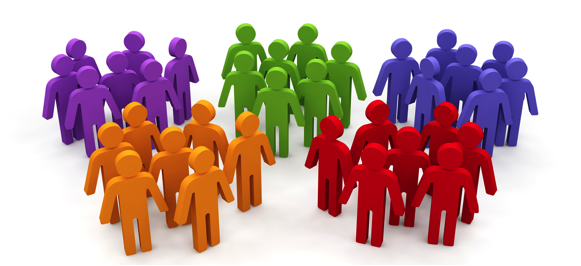

# **Data Preparation**

## **Importing and Inspecting Dataset**

In [82]:
# Importing required libraries
import numpy as np
# To handle the dataset
import pandas as pd

# For plots and visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer

# For getting optimal number of clusters in hierarchical clustering
from scipy.cluster.hierarchy import dendrogram,linkage
# To scale the data
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# metrics to evaluate the clusters
from sklearn.metrics import silhouette_score, silhouette_samples
# Clustering alorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# Display utilities
from IPython.display import Markdown, display

# activating DND to disregard the warnings by goiing silent mode
import warnings
warnings.filterwarnings('ignore')

# setting default parameters for the plots
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.dpi"] = 150

In [83]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining url of saved csv file
url = ('/content/drive/MyDrive/Online Retail.xlsx')


# Importing dataset to create a dataframe
df = pd.read_excel(url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Checking shape of dataframe
df.shape

In [ ]:
# Checking top 5 records
df.head()

In [ ]:
# Checking bottom 5 records
df.tail()

In [ ]:
# Basic Info of the dataset
df.info()

In [ ]:
# Descriptive Statistics
df.describe(percentiles=[0.01,0.25,0.5,0.75,0.99]).T

In [ ]:
# Checking number of unique values in each column
for col in df.columns:
  print(col,':',df[col].nunique())

##**Data cleaning**

In [ ]:
# Missing data counts and percentage
print('Missing Data Count')
print(df.isnull().sum())
print('--'*12)
print('Missing Data Percentage')
print((df.isnull().sum()/df.shape[0])*100)

1. **24.93%** of items purchases are not assigned to any customer
2. Hence there is no use of having the data with no customer assignment.
3.Because we can't form clusters without CustomerID so we will delete them from dataset.

In [ ]:
# Dropping the rows with nulls
df.dropna(inplace=True)

In [ ]:
# Checking duplicates
print(len(df[df.duplicated()]))

In [ ]:
# Dropping duplicate rows
df.drop_duplicates(inplace=True)

In [ ]:
# New Shape
df.shape

In [ ]:
df.info()

##**Feature Engineering**

In [ ]:
# Creating new features from the datetime column InvoiceDate
df['year']        = df['InvoiceDate'].apply(lambda x : x.year)
df['month']       = df['InvoiceDate'].apply(lambda x : x.month)
df['month_name']  = df['InvoiceDate'].apply(lambda x : x.month_name())
df['day_name']    = df['InvoiceDate'].apply(lambda x : x.day_name())
df['hour']        = df['InvoiceDate'].apply(lambda x : x.hour)

In [ ]:
df.head()

In [ ]:
# Creating a new feature 'TotalAmount' by multiplying Quantity and UnitPrice
df['TotalAmount'] = df['Quantity']*df['UnitPrice']

In [ ]:
# Creating a new feature 'TimeType' based on hours to define whether its Morning,Afternoon or Evening
df['TimeType'] = np.where((df['hour']>5) & (df['hour']<18), np.where(
                          df['hour']<12,'Morning','Afternoon'),'Evening')

In [ ]:
# Checking the number of cancellations by each customer. InvoiceNo starting with 'C' represents cancellation
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
cancellations = df[df['InvoiceNo'].str.contains('C')]
# cancellations = df[df['InvoiceNo'].str.contains('C')].groupby('CustomerID')['InvoiceNo'].count().reset_index()

# # InvoiceNo starting with 'C' represents cancellation
# dataset['InvoiceNo'] = dataset['InvoiceNo'].astype('str')
# cancellations = dataset[dataset['InvoiceNo'].str.contains('C')]
# cancellations.head()

In [ ]:
# Dropping cancellations from the main dataframe
df=df[~df['InvoiceNo'].str.contains('C')]

In [ ]:
df.shape

## **Exploratory Data Analysis**

In [ ]:
# Plotting top values based on frequency in each column
target = ['StockCode', 'Description','Quantity','UnitPrice', 'CustomerID', 'Country',
          'year', 'month_name','day_name','hour','TimeType']
plt.figure(figsize=(18,25))
for n,col in enumerate(target):
  plt.subplot(6,2,n+1)
  temp = df[col].value_counts().sort_values(ascending=False).head(12).reset_index()
  temp.rename(columns={'index' : col,col:'counts'},inplace=True)
  sns.barplot(x=col, y = 'counts' ,data=temp )
  plt.title(f'value counts of {col}')
  plt.xticks(rotation=20,ha='right')
  plt.tight_layout()
 

In [ ]:
# Plotting Bottom values based on frequency in each column
target = ['StockCode', 'Description','Country']

plt.figure(figsize=(18,4))
for n,col in enumerate(target):
  plt.subplot(1, 3, n+1)
  temp = df[col].value_counts().reset_index().tail(5)
  temp.rename(columns={'index': col, col:'count'}, inplace=True)
  sns.barplot(x=col ,y='count', data=temp).set(title=col.title())
  plt.xticks(rotation=20,ha='right')
  plt.tight_layout()

Observations/Hypothesis:
1. Most Customers are from United Kingdom. Considerable number of customers are also from Germany, France, EIRE and Spain. Whereas Saudi Arabia, Bahrain, Czech Republic, Brazil and Lithuania has lest number of customers 
2. There are no orders placed on Saturdays. Looks like its a non working day for the retailer.
3. Most numbers of customers have purched the gifts in the month of November ,October and December September
less numbers of customers have purches the gifts in the month of April ,january and February.
4. Most of the customers have purched the items in Aftrnoon ,moderate numbers of customers have purched the items in Morning and the least in Evening.
5. WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, JUMBO BAG RED RETROSPOT are the most ordered products

In [ ]:
# Visualizing the distributions.
target = ['Quantity','UnitPrice','TotalAmount']
plt.figure(figsize=(18,4))
for n,col in enumerate(target):
  plt.subplot(1,3,n+1)
  sns.distplot(df[col])
  plt.title(col)
  plt.tight_layout()

Observation:
1. It shows a positively skewed distribution because most of the values are clustered around the left side of the distribution while the right tail of the distribution is longer, which means mean>median>mode
2. For symmetric graph mean=median=mode.

In [ ]:
# Visualizing the distributions after log transformation of Quantity
plt.figure(figsize=(12,5))
sns.distplot(np.log(df['Quantity']))
plt.title('log distribution of Quantity')

In [ ]:
# Most orders placed are from these countries
country_invoice = df.groupby("Country").nunique()["InvoiceNo"].reset_index().sort_values("InvoiceNo",ascending=False)
country_invoice.rename(columns={'InvoiceNo': 'Invoice_Count'}, inplace=True)
country_invoice.head()

* United Kingdom is making most of the purchases as compared to other countries

In [ ]:
# Visualizing top and bottom 10 countries based on total invoices 
plt.figure(figsize=(20,5),dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Most orders placed are from these countries")
sns.barplot(data=country_invoice.head(10),x="Country",y="Invoice_Count")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Least orders placed are from these countries")
sns.barplot(data=country_invoice.tail(10),x="Country",y="Invoice_Count")
plt.show()

In [ ]:
# Most customers are from these countries
country_cust = df.groupby("Country").nunique()["CustomerID"].reset_index().sort_values("CustomerID",ascending=False)
country_cust.rename(columns={'CustomerID': 'Customer_Count'}, inplace=True)
country_cust.head()

* United Kingdom has most number of customers 

In [ ]:
# Visualizing top and bottom 10 countries based on total customers 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Most customers are from these countries")
sns.barplot(data=country_cust.head(10),x="Country",y="Customer_Count")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Least customers are from these countries")
sns.barplot(data=country_cust.tail(10),x="Country",y="Customer_Count")
plt.show()

In [ ]:
# Countrywise average item purchases
country_quantity = df.groupby("Country").mean()["Quantity"].reset_index().sort_values("Quantity",ascending=False)
country_quantity.rename(columns={'Quantity': 'Average_Quantity'}, inplace=True)
country_quantity.head()

* Orders with mass quantity are placed by the customers from Netherlands

In [ ]:
# Visualizing top and bottom 10 countries based on average item purchases 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("High quantity orders are from these countries")
sns.barplot(data=country_quantity.head(10),x="Country",y="Average_Quantity")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Low quantity orders are from these countries")
sns.barplot(data=country_quantity.tail(10),x="Country",y="Average_Quantity")
plt.show()

In [ ]:
# quantity wise item purchases
product_quantity = df.groupby("Description").sum()["Quantity"].reset_index().sort_values("Quantity",ascending=False)
product_quantity.head()

In [ ]:
# Visualizing top and bottom 10 products based on purchase quantity
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Product with High quantity orders")
sns.barplot(data=product_quantity.head(10),x="Description",y="Quantity")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Product with low quantity orders")
sns.barplot(data=product_quantity.tail(10),x="Description",y="Quantity")
plt.show()

In [ ]:
# Amount wise item purchases
product_price = df.groupby("Description").sum()["TotalAmount"].reset_index().sort_values("TotalAmount",ascending=False)
product_price.head()

In [ ]:
# Visualizing top and bottom 10 products based on amount
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Product that made most of the revenue")
sns.barplot(data=product_price.head(10),x="Description",y="TotalAmount")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Product that made least revenue")
sns.barplot(data=product_price.tail(10),x="Description",y="TotalAmount")
plt.show()

In [ ]:
# customer wise item purchases
product_customer = df.groupby("Description").nunique()["CustomerID"].reset_index().sort_values("CustomerID",ascending=False)
product_customer.rename(columns={'CustomerID': 'Customer_Count'}, inplace=True)
product_customer.head()

In [ ]:
# Visualizing top and bottom 10 products based on customers
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("Product with large customer base")
sns.barplot(data=product_customer.head(10),x="Description",y="Customer_Count")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("Product with small customer base")
sns.barplot(data=product_customer.tail(10),x="Description",y="Customer_Count")
plt.show()

In [ ]:
# Checking the number of cancellations by each customer. 
customer_cancellations = cancellations.groupby('CustomerID').count()['InvoiceNo'].reset_index().sort_values('InvoiceNo',ascending=False)
customer_cancellations.rename(columns={'InvoiceNo': 'Cancellations'}, inplace=True)
customer_cancellations.head()

In [ ]:
# Visualizing top and bottom 10 customers based on cancellations 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("customer with High cancellations")
sns.barplot(data=customer_cancellations.head(10),x="CustomerID",y="Cancellations")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("customer with low cancellations")
sns.barplot(data=customer_cancellations.tail(10),x="CustomerID",y="Cancellations")
plt.show()

In [ ]:
# Checking the number of cancellations countrywise. 
country_cancellations = cancellations.groupby('Country').count()['InvoiceNo'].reset_index().sort_values("InvoiceNo",ascending=False)
country_cancellations.rename(columns={'InvoiceNo': 'Cancellations'}, inplace=True)
country_cancellations.head()

In [ ]:
# Visualizing top and bottom 10 countries based on cancellations 
plt.figure(figsize=(20,5), dpi=90)
plt.subplot(1,2,1)
plt.xticks(rotation=20,ha='right')
plt.title("countries with High cancellations")
sns.barplot(data=country_cancellations.head(10),x="Country",y="Cancellations")

plt.subplot(1,2,2)
plt.xticks(rotation=20,ha='right')
plt.title("countries with low cancellations")
sns.barplot(data=country_cancellations.tail(10),x="Country",y="Cancellations")
plt.show()

## **RFM Segmentation**

1. Since Most of the Customers are wholesalers we cannot group customers based on the demographic group like age, gender, income and behavioral and psycho-graphic group Because Our Customers purchase bunch of goods from us and sell it to individual customers.
2. We only need to deal issues and make clusters related to B2B Business to Business instead of B2C i.e. Direct from Business to Customers
WHY BECAUSE PEOPLE WHO PURCHASE PRODUCTS FROM US DO NOT UTILIZE IT
They sell it to individual customers(B2C) or sell all products to another stores (B2B)
3. Due to all these reasons we need to cluster customers according to there activities i.e
  1. R- Recency
  2. F- Frequency
  3. M- Monetary

In [ ]:
# Adding 1 day to the Last Invoice date to set as Latest date for reference
LatestDate = df["InvoiceDate"].max() + pd.DateOffset(days=1)

# Createing a new dataframe to calculate Recency, Frequency and Monetry scores for each customer
rfm = df.groupby('CustomerID').agg({'InvoiceDate':lambda x : (LatestDate-x.max()).days,'InvoiceNo': lambda x: len(x),'TotalAmount':lambda x: x.sum() })

# Renaming the columns
rfm.columns = ['Recency',	'Frequency' , 'Monetary']

In [ ]:
# Checking top 5 rows
rfm.head()

Interpretation:
1. Recency: How recent a customer made a purchase.
2. Frequency: How often a customer makes a purchase.
3. Monetary: How much money a customer spends.

In [ ]:
# Calculating R, F and M scores by splitting Recency, Frequency	and Monetary based on quantiles
rfm['R'] = pd.qcut(rfm['Recency'] , q=4, labels=[4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'], q=4, labels=[1,2,3,4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], q=4, labels=[1,2,3,4]).astype(int)


In [ ]:
# Finding the RFM Group for each customer by combining the factors R,Fand M
rfm['RFM'] = 100*rfm['R'] + 10*rfm['F'] + rfm['M']

# Finding the RFM Score for each customer by adding the factors R,Fand M
rfm['RFM_Score'] = rfm['R'] + rfm['F'] + rfm['M']

In [ ]:
# #adding segment column of type of customer [RFM in 4 segments based on quantiles]
# rfm['segment'] = pd.qcut(rfm['RFM_group'],q=4,labels=[1,2,3,4]).astype(int)
# rfm.head(3)

Interpretation:
1. If the RFM of any customer is 444. His Recency is good, frequency is more and Monetary is more. So, he is the best customer.
2. If the RFM of any customer is 111. His Recency is low, frequency is low and Monetary is low. So, he is the churning customer.
3. If the RFM of any customer is 144. He purchased a long time ago but buys frequently and spends more. And so on.
4. Like this we can come up with number of segments for all combinations of R,F and M base on our usecase. Higher the RFM score, more valuable the customer is.


In [ ]:
rfm.info()

In [ ]:
rfm.describe().T

In [ ]:
# Handling the zeroes in the dataframe to avoid error in transformations
rfm.replace(to_replace=0,value=1,inplace=True)

#log_transformation of  Recency	Frequency	 and Monetary
rfm['Recency_Log']   = rfm['Recency'].apply(np.log) 
rfm['Frequency_Log'] =rfm['Frequency'].apply(np.log) 
rfm['Monetary_Log'] = rfm['Monetary'].apply(np.log) 

rfm.head(3)

In [ ]:
#ploting graph before and after log transformation
target = ['Recency','Frequency', 'Monetary' ,'Recency_Log',	'Frequency_Log','Monetary_Log']

plt.figure(figsize=(18,8))
for n,cols in enumerate(target):
  plt.subplot(2,3,n+1)
  sns.distplot(rfm[cols])
  plt.title(cols)
  plt.tight_layout()

Observations:
1. Earlier the distributions of Recency, Frequency and Monetary columns were positively skewed but after applying log transformation, the distributions appear to be symmetrical and normally distributed.
2. It will be more suitable to use the transformed features for better visualisation of clusters.

In [ ]:
# Visualizing the correlations among features.
target = ['Recency_Log','Frequency_Log','Monetary_Log','RFM','RFM_Score']
plt.figure(figsize = (12, 8), dpi=100)
sns.heatmap(abs(rfm[target].corr()), annot=True, cmap='coolwarm')
plt.title('RFM Correlation Heatmap')
plt.show()

#**Clustering**

##**Prerequisites**

In [ ]:
# Defining X Variables
X = rfm[['Recency_Log','Frequency_Log','Monetary_Log']]
X = StandardScaler().fit_transform(X)

In [ ]:
# Initializing an empty dictionary to store the stats and summary for all clusters 
conclusion={}

# Definin a function to remove the outliers
def cap_outliers(col,overlap_supress):
  '''
    Takes a column and removes the outliers based on the overlap_supress value
    col: column to be cleaned
    overlap_supress: value to be used to remove the outliers
    Type:
    col: pandas.Series
    overlap_supress: float

    Returns:Capped column with outliers removed
  '''
  condition1=col < col.quantile(1-overlap_supress)
  condition2=col > col.quantile(overlap_supress)
  return col[condition1 & condition2]

# Function for displaying the stats of Recency, Frequency and Monetary for each group
def cluster_stats(data, segment_name):
  '''
    Type:data: pandas.DataFrame
    Type:segment_name: str
    Returns: pandas.DataFrame
    Features:This function prints the mean median and count of Recency, Frequency and Monetary for each group
    This function prints 0.25th and 0.75th Quantile of Recency, Frequency and Monetary for each group
  '''
  # Storing the mean median and count of Recency, Frequency and Monetary for each group
  stats = data[["Recency","Frequency","Monetary",segment_name]].groupby(segment_name).agg(['mean','median'])
  stats['Count'] = data[segment_name].value_counts()

  # Storing 0.25th and 0.75th Quantile of Recency, Frequency and Monetary for each group
  summary = data[["Recency","Frequency","Monetary",segment_name]].groupby(segment_name).agg({
          "Recency"   :lambda x : f'{int(x.quantile(0.25))} to {int(x.quantile(0.75))} days ago',
          "Frequency" :lambda x : f"Bought {int(x.quantile(0.25))} to {int(x.quantile(0.75))} times",
          "Monetary"  :lambda x : f"Spent around {int(x.quantile(0.25))} to {int(x.quantile(0.75))} Sterling"})
  
  # Changing the name for the columns 
  stats.columns = [f'{i}_{j}' for i, j in stats.columns]
  summary.columns=["Last_visited",'Purchase_frequency',"Money_spent"]

  return stats, summary

# Defining a function for plotting clusters for Visualization
def plots_stats_summary(y, segment_name, title, overlap_supress=0.2):
  '''
  Arguments:
    Type:y: pandas.Series
    Type:title: str
    Type:segment_name: str
    Type:overlap_supress: float
  Returns: Array of DataFrames
  features:This function plots the clusters for the given data and returns the dataframes for the clusters with conclusions and stats
  '''
  rfm[segment_name] = y                                               # Copying segment values to main data frame
  groups = sorted(rfm[segment_name].unique())                         # store legends for features.
  # Calling the cluster_stats Function and saving outputs into variable
  stats, summary = cluster_stats(rfm,segment_name) 

  # PART 1 : Visyualizing the scatter plots for all clusters
  plt.figure(figsize = (18, 6), dpi=90)                               # Setting the size of the figure
  ax = plt.axes(projection ="3d")                                     # initializing axes
  ax.set_xlabel('Recency', fontweight ='bold')                        # Setting X label
  ax.set_ylabel('Frequency', fontweight ='bold')                      # Setting Y label
  ax.set_zlabel('Monetary', fontweight ='bold')                       # Setting Z label
  ax.set_title(title, fontweight ='bold')                             # Setting main title
  ax = ax.scatter(X[:, 0], X[:, 1], X[:, 2] ,c=y, cmap='viridis')     # Plotting scatter plot in 3 dimensions
  plt.legend(*ax.legend_elements(),prop={'size': 15})                 # positioning legend

  # PART 2 : Plotting the distribution
  fig,ax = plt.subplots(3,figsize=(18, 18), dpi=90)                  # Setting the size of the figure
  # Running a for loop for iterating through the number of clusters
  for i in groups:
    # Running a for loop for iterating through columns
    for index, col in enumerate(["Recency", "Frequency", "Monetary"]):
      # Plotting distributions of Recency, Frequency and Monetary
      sns.distplot(cap_outliers(rfm[rfm[segment_name]==i][col], overlap_supress),ax=ax[index] ,kde_kws=dict(linewidth=5))
      ax[index].set_title(f'{col} Distribution', fontweight ='bold')  # Setting the main title
      ax[index].legend(groups,prop={'size': 15})                      # Assiging legends for all the axes
  plt.show()

  # PART 3 : # Displaying the stats and summary
  # Displaying the mean median and count of Recency, Frequency and Monetary for each group
  print('\n\nDisplaying the mean median and count of Recency, Frequency and Monetary for each group with the description:\n')
  display(stats.reset_index().style.hide_index().background_gradient(cmap="plasma"))
  display(summary.reset_index().style.set_properties(**{'text-align': 'left'}).hide_index().background_gradient(cmap="plasma"))

  return stats, summary

##**Binning RFM_Score**

In [ ]:
# Splitting RFM_Score in 4 bins based on quantiles
y = pd.qcut(rfm['RFM_Score'], q=4, labels=[1,2,3,4]).astype(int)

# Plotting Segments for Visualization
title = 'RFM_Score Binning'
segment_name = 'Binning'
overlap_supress = 0.25
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

##**Quantile Based Clustering**

In [ ]:
# Splitting RFM in 4 segments based on quantiles to obtain segments
y = pd.qcut(rfm['RFM'], q=4, labels=[1,2,3,4]).astype(int)

# Plotting Segments for Visualization
title = 'RFM Quantile Based Segmentation'
segment_name = 'QuantileCut'
overlap_supress = 0.25
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

##**K-Means Clustering**

In [ ]:
# Storing sum of squared distances and Silhouette Scores for each value of k in k means clusterer
ssd,score = [],[]
# Setting figure Size
plt.figure(figsize=(20,5), dpi=90)

# Initializing the list of clusters for tuning the best clusters
n_clusters = list(range(2,16))

# Running a for loop of Kmeans algorithm
for k in n_clusters:
    clusterer = KMeans(n_clusters = k, init= 'k-means++', max_iter= 1000)
    y_preds = clusterer.fit_predict(X)                                          # Fitting the model
    ssd.append(clusterer.inertia_)                                              # Appending the inertia
    score.append(silhouette_score(X, y_preds))                                  # Appending the silhoutte score

# Plotting Elbow curve to find optimal K
plt.subplot(1, 2, 1)                                                            #Initializing subplots
sns.pointplot(x=n_clusters, y=ssd)                                              # plotting point plot
plt.xlabel('Number of Clusters(k)')                                             # Setting x label
plt.ylabel('Sum of Squared Distances')                                          # Setting y label
plt.title('Elbow Curve')                                                        # Setting the title

# Silhouette Score v/s Number of Clusters
plt.subplot(1, 2, 2)                                                            #Initializing subplots
sns.barplot(x=n_clusters, y=score)                                              # plotting bar plot
plt.xlabel('Number of Clusters(k)')                                             # Setting x label
plt.ylabel('Silhouette Score')                                                  # Setting y label
plt.title('Silhouette Scores')                                                  # Setting the title
plt.tight_layout()

Observations:
1. From the Elbow curve 5 appears to be at the elbow and hence can be considered as the number of clusters. n_clusters=4 or 6 can also be considered based of the objective of segmentation.
2. If we go by maximum Silhouette Score as the criteria for selecting optimal number of clusters, then n_clusters=2 can be chosen.
3. If we look at both of the graphs at the same time to decide the optimal number of clusters, we can take the intersection of set of good n_clusters obtained from both the graphs. So 4 appears to be a good choice, having a decent Silhouette score as well as near the elbow of the elbow curve.

In [ ]:
# Visualizing the Silouette plots for the clusters
for i in range(2,7):
    plt.figure(figsize = (8, 3), dpi=150)
    kmeans=KMeans(i,init="k-means++")
    visualizer=SilhouetteVisualizer(kmeans,colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()

In [ ]:
# Fitting the model on n_clusters = 2 based on Silhouette_Score to visualise the segments.
kmc = KMeans(n_clusters=2,init="k-means++")             # Setting 2 Clusters
y = kmc.fit_predict(X)                                  # FItting the model
centers = kmc.cluster_centers_                          # Storing the centriods

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Silhouette_Score'  # Setting the title
segment_name = 'K-Means|2Cluster'
overlap_supress = 0.1
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

In [ ]:
# Fitting the model on n_clusters = 5 based on Elbow_Curve to visualise the segments.
kmc = KMeans(n_clusters=5,init="k-means++")           # Setting 5 Clusters
y = kmc.fit_predict(X)                                # Fitting the model
centers = kmc.cluster_centers_                        # Storing the centriods

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Elbow_Curve'     # Setting the title
segment_name = 'K-Means|5Cluster'
overlap_supress = 0.2
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

In [ ]:
# Fitting the model on n_clusters = 4 based on Both Elbow_Curve & Silhouette_Score to visualise the segments.
kmc = KMeans(n_clusters=4,init="k-means++")         # Setting 4 Clusters
y = kmc.fit_predict(X)                              # Fitting the model
centers = kmc.cluster_centers_                      # Storing the centriods

# Plotting Clusters for Visualization
title = 'K-Means Clustering based on Both Elbow_Curve & Silhouette_Score'         # Setting the title
segment_name = 'K-Means|4Cluster'
overlap_supress = 0.2
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

##**Hierarchical Clustering**

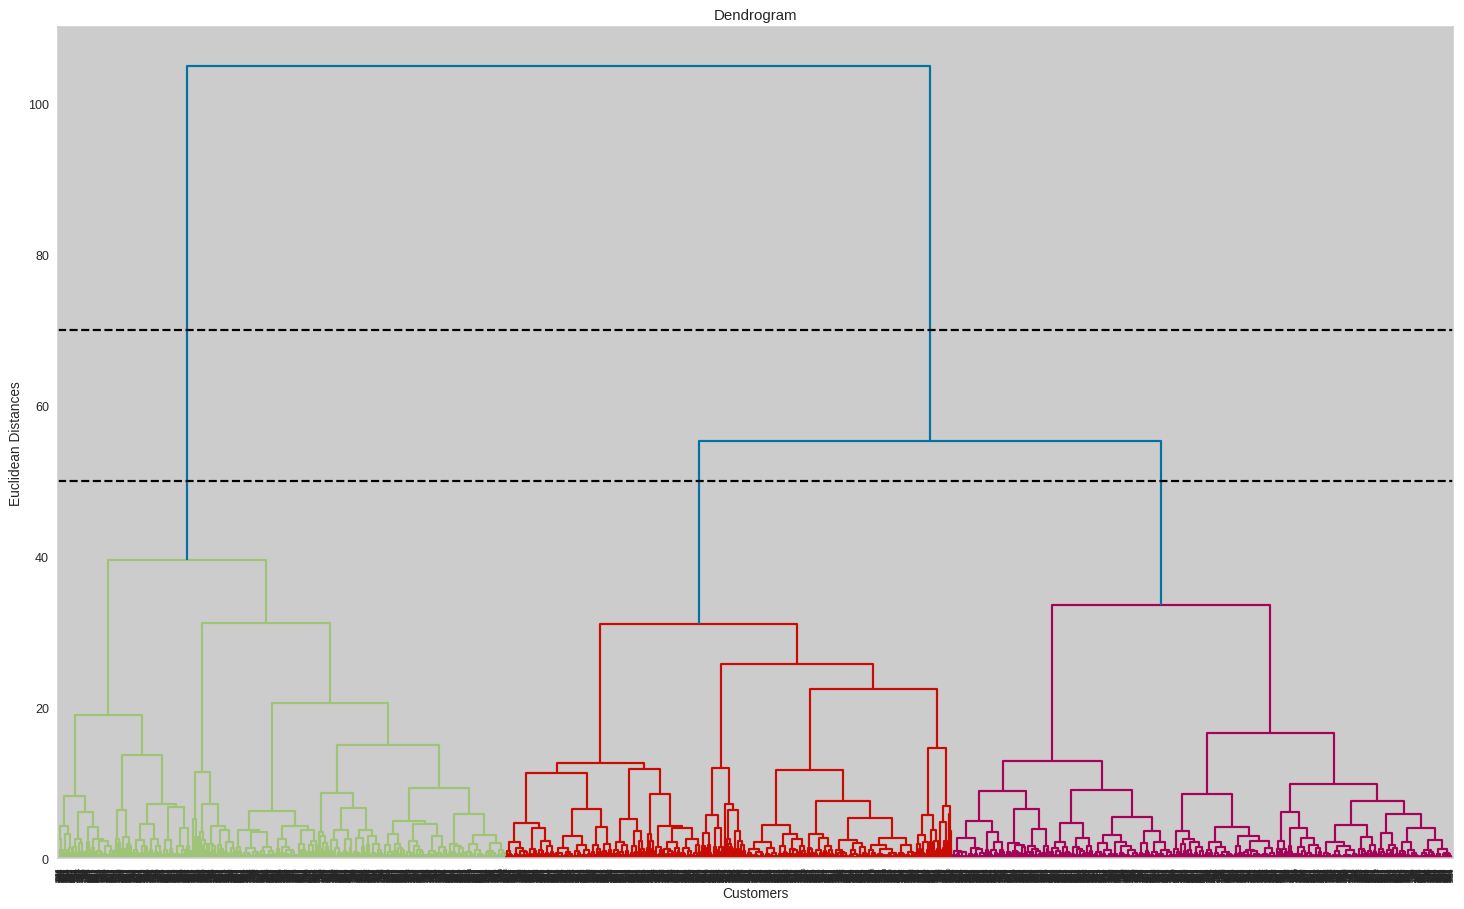

In [66]:
# Using the Dendogram to Decide the number of clusters
plt.figure(figsize=(20,12), dpi=90)                         # Setting the figure size
dendrogram(linkage(X, method='ward'), color_threshold=50)   # using ward linkage method to differ similarities
plt.title('Dendrogram')                                     # Setting the title
plt.xlabel('Customers')                                     # Setting the x label
plt.ylabel('Euclidean Distances')                           # Setting y label
plt.axhline(y=70, color='black', linestyle='--')            # Setting the axis line for y=70
plt.axhline(y=50, color='black', linestyle='--')            # Setting the axis line for y=50
plt.show()

Interpretation:
1. We can set a threshold distance and draw a horizontal line (Generally, we try to set the threshold in such a way that it cuts the tallest vertical line). We can set this threshold as 50 or 70 and draw a horizontal line as shown in dendogram above.
2. The number of clusters will be the number of vertical lines which are being intersected by the line drawn using the threshold. The larger threshold (y=70) results in 2 clusters while the smaller (y=50) results in 3 clusters.

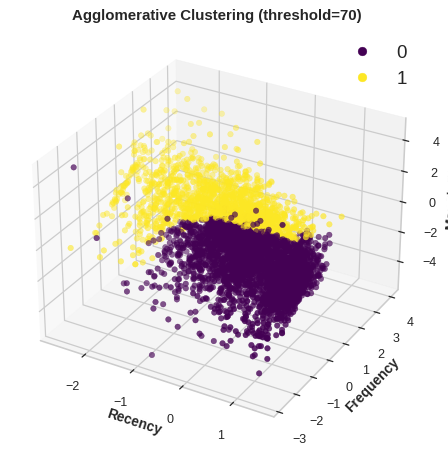

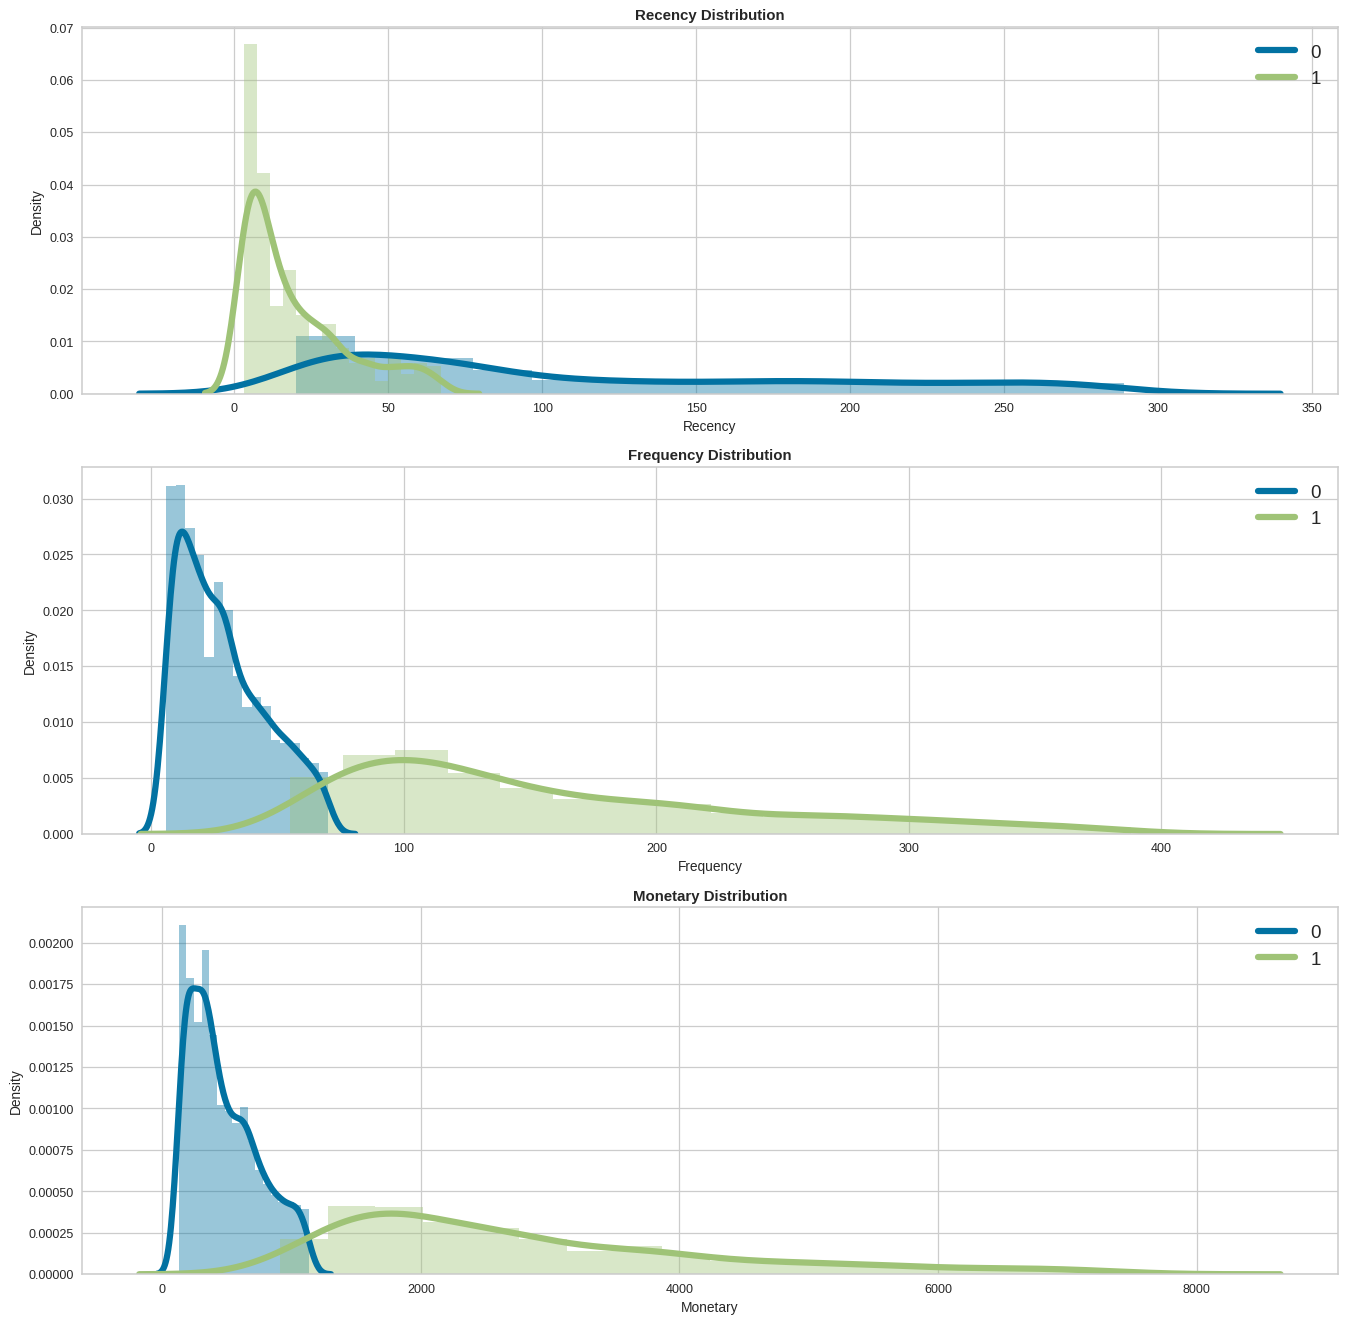



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



hierarchical|2Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,123.608696,80.000000,33.610394,25.000000,684.108391,409.685000,2944
1,26.905376,12.000000,210.597133,135.000000,4927.021356,2404.170000,1395


hierarchical|2Cluster,Last_visited,Purchase_frequency,Money_spent
0,36 to 200 days ago,Bought 12 to 46 times,Spent around 219 to 739 Sterling
1,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling


In [67]:
# Fitting hierarchical clustering with number of clusters based on dendogram distance threshold = 70
ahc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')     # Initializing the model
y = ahc.fit_predict(X)                                                                # Fitting and predicting the model

# Lets visualize the clusters with n_clusters = 2
title = 'Agglomerative Clustering (threshold=70)'                                     # Setting the title
segment_name = 'hierarchical|2Cluster'
overlap_supress = 0.1
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

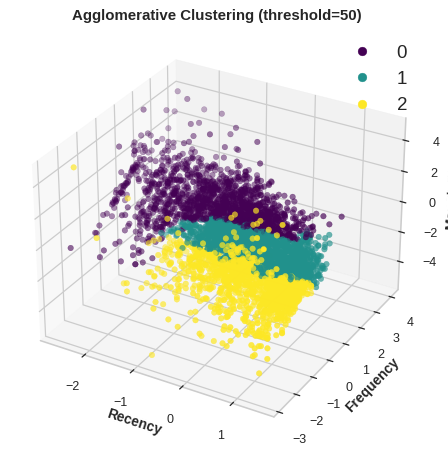

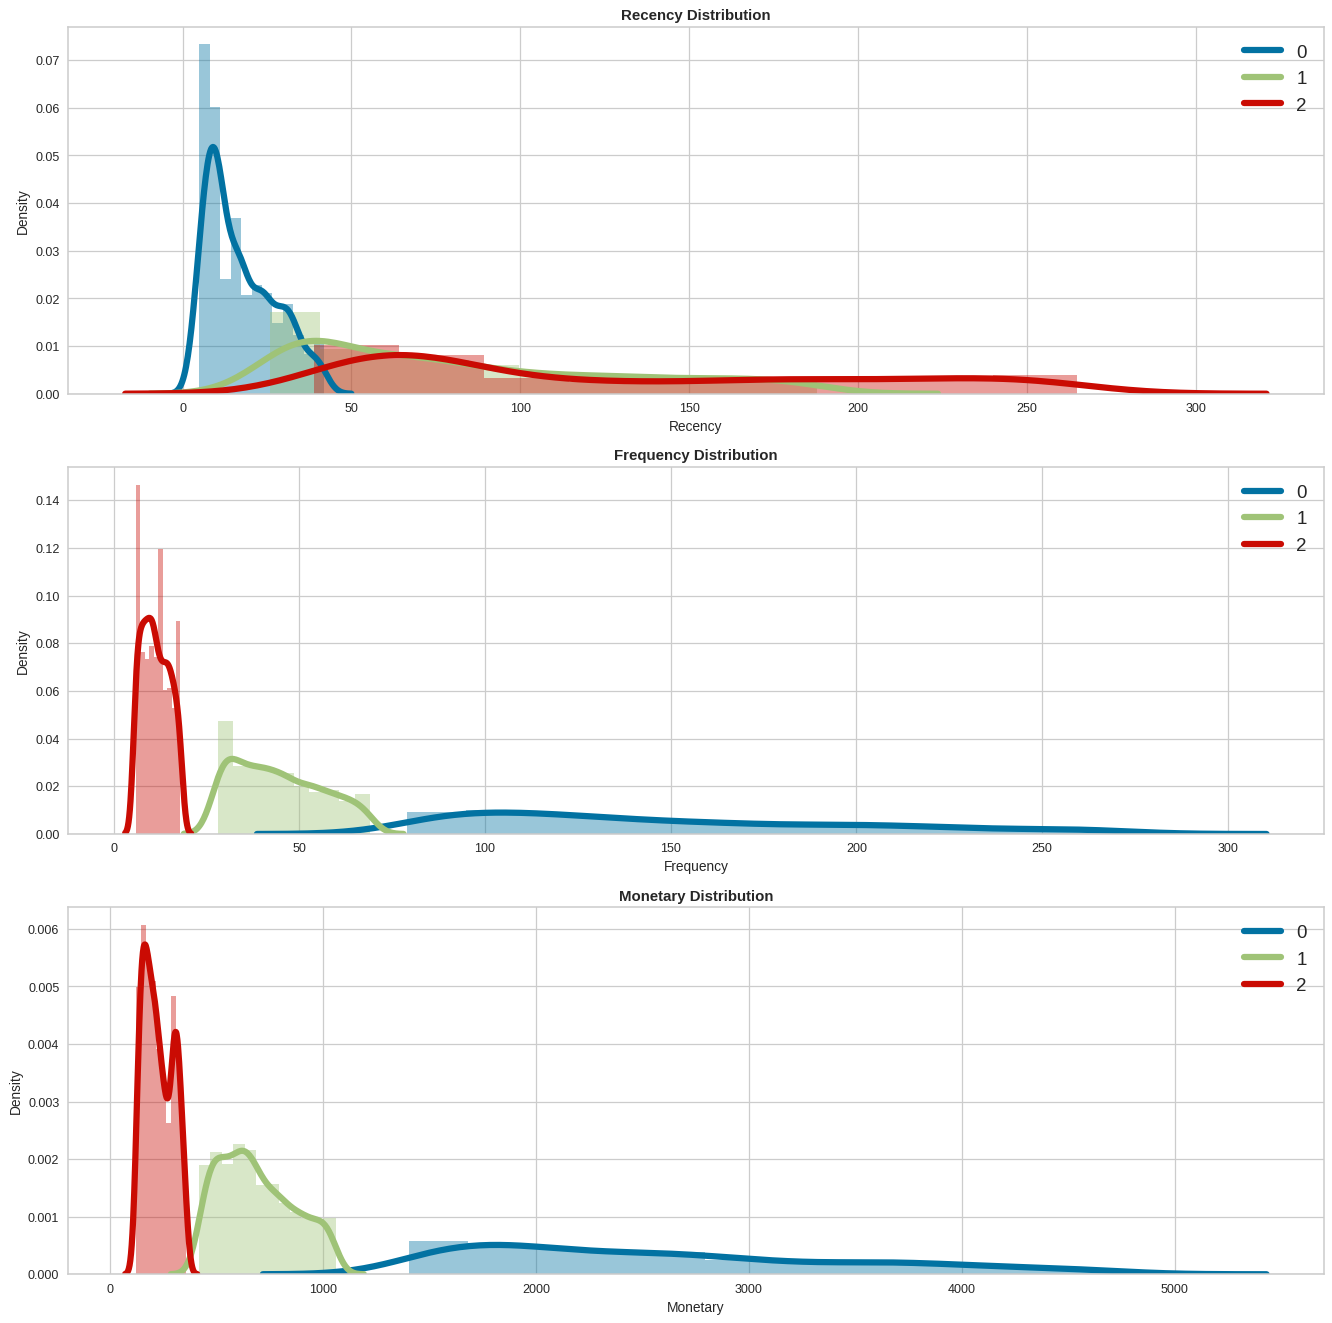



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



hierarchical|3Cluster,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
0,26.905376,12.000000,210.597133,135.000000,4927.021356,2404.170000,1395
1,105.246312,71.000000,51.658114,43.000000,756.610450,657.300000,1559
2,144.277978,99.000000,13.295307,11.000000,602.497770,215.480000,1385


hierarchical|3Cluster,Last_visited,Purchase_frequency,Money_spent
0,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling
1,30 to 163 days ago,Bought 29 to 63 times,Spent around 463 to 977 Sterling
2,49 to 243 days ago,Bought 6 to 18 times,Spent around 139 to 327 Sterling


In [68]:
# Fitting hierarchical clustering with number of clusters based on dendogram distance threshold = 50
ahc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')     # Initializing the model
y = ahc.fit_predict(X)                                                                # Fitting and predicting the model

# Lets visualize the clusters with n_clusters = 3
title = 'Agglomerative Clustering (threshold=50)'                                     # Setting the title
segment_name = 'hierarchical|3Cluster'
overlap_supress = 0.2
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

##**DBScan Clusterer**

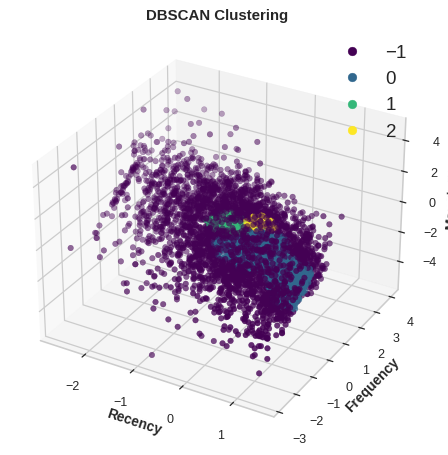

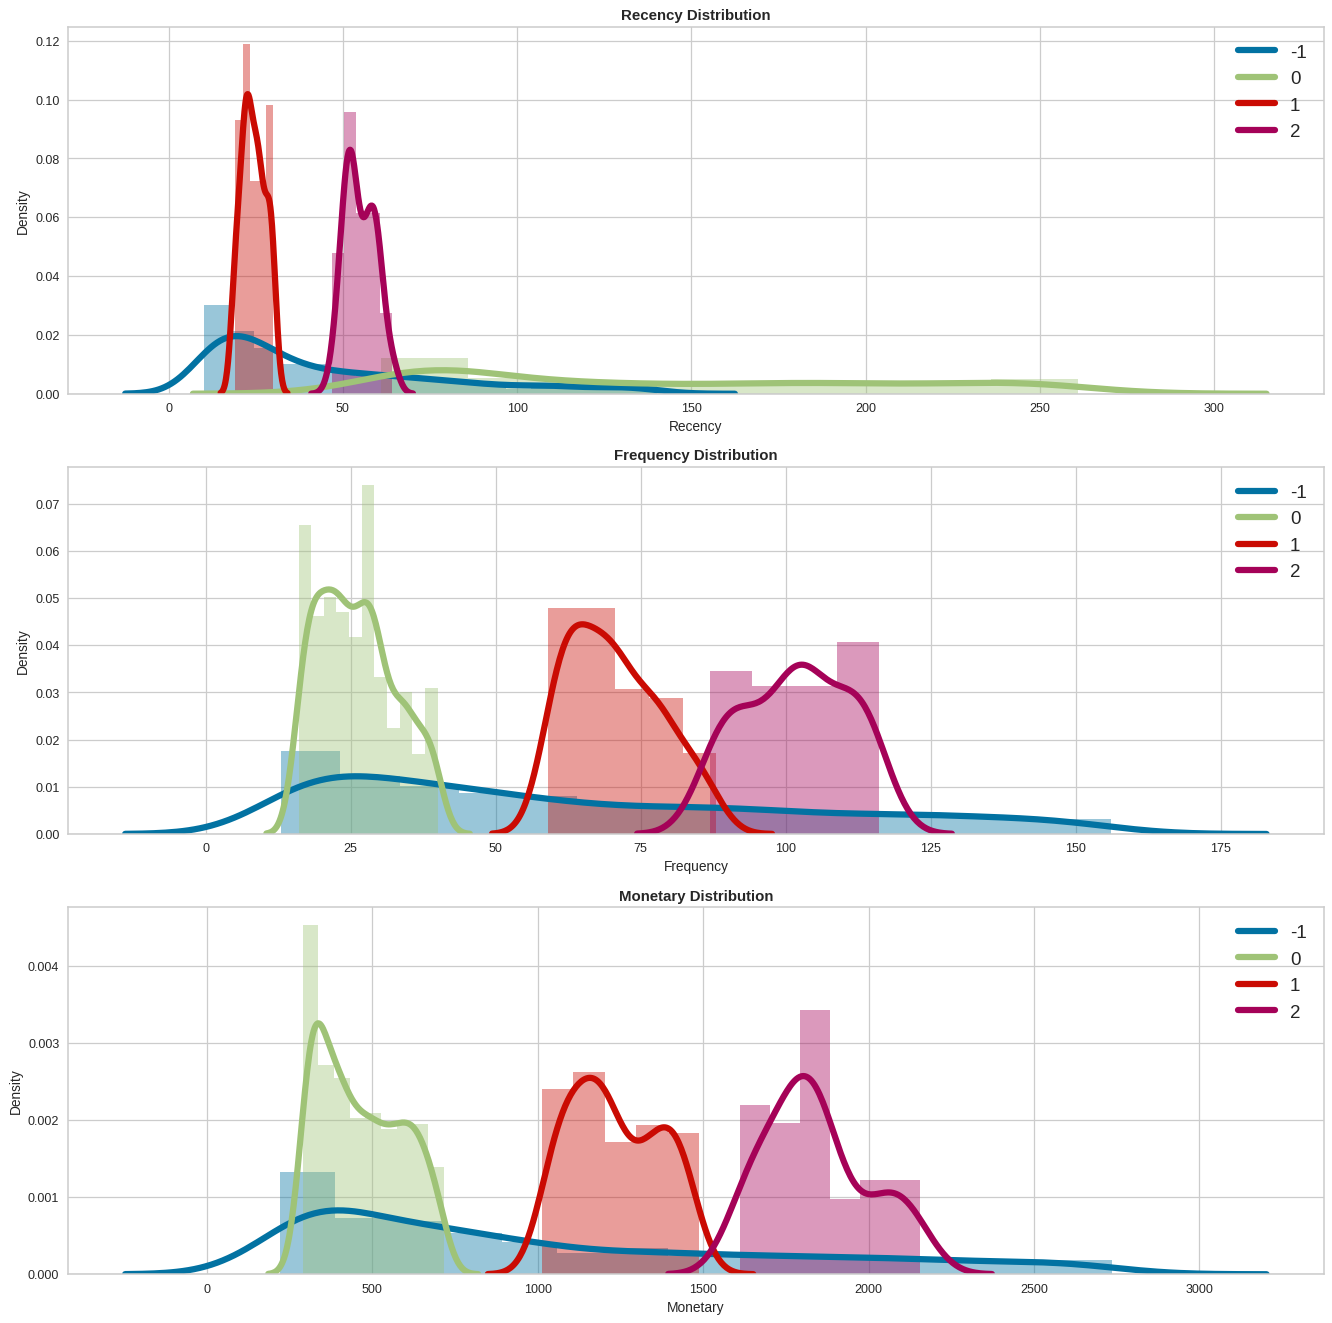



Displaying the mean median and count of Recency, Frequency and Monetary for each group with the description:



DBSCAN,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Count_
-1,76.209745,32.000000,111.290416,52.000000,2591.443756,797.960000,3099
0,155.415430,124.000000,28.556874,25.000000,514.588776,451.440000,1011
1,25.253247,24.500000,73.376623,69.500000,1264.077597,1212.910000,154
2,56.653333,54.000000,102.293333,102.000000,1885.446533,1824.230000,75


DBSCAN,Last_visited,Purchase_frequency,Money_spent
-1,11 to 107 days ago,Bought 15 to 130 times,Spent around 278 to 2245 Sterling
0,66 to 245 days ago,Bought 17 to 37 times,Spent around 309 to 658 Sterling
1,19 to 30 days ago,Bought 60 to 84 times,Spent around 1052 to 1425 Sterling
2,50 to 62 days ago,Bought 89 to 114 times,Spent around 1637 to 2094 Sterling


In [69]:
# Fitting DBSCAN clusterer
dbsc = DBSCAN(eps=0.2, min_samples=25)                                # Initializing the model
y = dbsc.fit_predict(X)                                               # Fitting the model

# Plotting Clusters for Visualization
title = 'DBSCAN Clustering'                                           # Setting the title
segment_name = 'DBSCAN'
overlap_supress = 0.2
conclusion[segment_name] = plots_stats_summary(y, segment_name, title, overlap_supress)

1. Density-based spatial clustering of applications with noise (DBSCAN) is an alternative to KMeans and hierarchical clustering. It does not require us to specify the number of clusters, as the clusters are formed by a process of linking neighbor points together.
2. It avoids outliers and identifies nested clusters within the data. The data is muddled and does not have major visible nested cluster, yet it has identified 3 clusters as shown above based on the hyperparameters defined.

#**Conclusion**

1. We started with a simple binning and quantile based simple segmentation model first then moved to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.
2. Then we moved to k-means clustering and visualized the results with different number of clusters. As we know there is no assurance that k-means will lead to the global best solution. We moved forward and tried Hierarchical Clustering and DBSCAN clusterer as well.
3. We created several useful clusters of customers on the basis of different metrics and methods to cateorize the customers on the basis of their beavioural attributes to define their valuability, loyality, profitability etc for the business. Though significantly separated clusters are not visible in the plots, but the clusters obtained is fairly valid and useful as per the  algorithms and the statistics extracted from the data.
4. Segments depends on how the business plans to use the results, and the level of granularity they want to see in the clusters. Keeping these points in view we clustered the major segments based on our understanding as per diffrent criteria as shown in the summary dataframe.


In [70]:
# Summarizing the results obtained by clustering using various methods
summary = pd.DataFrame({"Clusterer": ['Binning','Quantile Cut', "K-Means", "K-Means", "K-Means", "Agglomerative","Agglomerative", "DBSCAN"],
                        'Criterion': ['RFM Score Binning', 'RFM Quantile Cut', 'Elbow Curve', 'Silhouette Score','Elbow Curve & Silhouette Score',
                                      'Dendogram (y=70)', 'Dendogram (y=50)', 'eps=0.2, min_samples=25'],
                        "Segments" : [4,4,5,2,4,2,3,4]},
                        index=['', '', '', '', '', '', '', ''])
summary.T

,,,,,,,,
Clusterer,Binning,Quantile Cut,K-Means,K-Means,K-Means,Agglomerative,Agglomerative,DBSCAN
Criterion,RFM Score Binning,RFM Quantile Cut,Elbow Curve,Silhouette Score,Elbow Curve & Silhouette Score,Dendogram (y=70),Dendogram (y=50),"eps=0.2, min_samples=25"
Segments,4,4,5,2,4,2,3,4


NOTE ALL THE VALUES SHOWN ARE APPROX!!

**VALUES MIN AND MAX ARE TAKEN FROM 25th PERCENTILE and 75th PERCENTILE OF FEATURES RESPECTIVELY** 






## **Helper Functions**

In [71]:
# Defining a function to print the output in the form of MarkDown 
def printmd(string):
  '''
  col String : Type: String
  returns :MARKDOWN
  This functions allows us to print the output in the form of MarkDown 
  '''
  display(Markdown(string))
 
# Setting List of 5 types of customers based on activities of the customer
customers_type=["❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <br>❌❌❌LOST POOR CUSTOMERS❌❌❌<br> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌",
                '🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉 <br>🥉🥉🥉AVERAGE CUSTOMERS🥉🥉🥉<br>  🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉',
                '❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤<br>❤❤RECENTLY VISITED AVERAGE CUSTOMERS❤❤<br> ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤',
                ' 🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈 <br> 🥈🥈🥈GOOD CUSTOMERS🥈🥈🥈 <br> 🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈',
                '💓💓💓💓💓💓💓💓💓💓💓💓 <br> 💓💓💓BEST CUSTOMERS💓💓💓 <br> 💓💓💓💓💓💓💓💓💓💓💓💓',
                "❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <br>❌❌LOSING LOYAL CUSTOMERS❌❌<br> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌"]

customers_type_=["LOST POOR CUSTOMERS❌",
                'AVERAGE CUSTOMERS🥉',
                'RECENTLY VISITED AVERAGE CUSTOMERS❤',
                'GOOD CUSTOMERS🥈',
                'BEST CUSTOMERS💓',
                 'LOSING LOYAL CUSTOMERS❌']                

In [72]:
# Initializing an empty dict to store rank lists
rank_list_dict={}

# Defining a function to print the conclusion based on the summary dataframe stored in conclusion dict
def printing_conclusion(segment_name):
  '''
  segment_name:Name of the clusters being passed TYPE:String
  Returns Conclusion of grouped customer based on clustering algorithm
  Features This functions returns the Conclusion of the grouped customers segmented from clustering algorithm 
  '''
  # Storing the conclusion data frame into variable 
  dataframe = conclusion[segment_name][1]
  # Displaying the conclusion dataframe
  display(dataframe.reset_index().style.set_properties(**{'text-align': 'left'}).hide_index().background_gradient(cmap="plasma"))

  print(70*"__") 
  print(70*"__")
  # Iterating for loop over all the segments
  for id,i in enumerate(dataframe.index):
    print("")
    printmd(f""" <h1><center><font size="4"> {segment_name} {i}: Customers Visited Stores around {dataframe.loc[i,'Last_visited']}, 
            has {dataframe.loc[i,'Purchase_frequency']} and has {dataframe.loc[i,'Money_spent']}</font><br><font size=6>
            {customers_type[rank_list_dict[segment_name][id]]}</center></h1><br></font>""".upper())
    print(70*"__")
    print(70*"__")

## **1. Binning (4 Clusters)**

In [73]:
# DEfining the segment name
segment_name = 'Binning'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [0,1,3,4]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

Binning,Last_visited,Purchase_frequency,Money_spent
1,93 to 274 days ago,Bought 7 to 20 times,Spent around 142 to 335 Sterling
2,31 to 114 days ago,Bought 19 to 41 times,Spent around 327 to 725 Sterling
3,16 to 65 days ago,Bought 46 to 98 times,Spent around 717 to 1613 Sterling
4,4 to 19 days ago,Bought 123 to 305 times,Spent around 2093 to 5398 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> BINNING 1: CUSTOMERS VISITED STORES AROUND 93 TO 274 DAYS AGO, 
            HAS BOUGHT 7 TO 20 TIMES AND HAS SPENT AROUND 142 TO 335 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> BINNING 2: CUSTOMERS VISITED STORES AROUND 31 TO 114 DAYS AGO, 
            HAS BOUGHT 19 TO 41 TIMES AND HAS SPENT AROUND 327 TO 725 STERLING</FONT><BR><FONT SIZE=6>
            🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉 <BR>🥉🥉🥉AVERAGE CUSTOMERS🥉🥉🥉<BR>  🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> BINNING 3: CUSTOMERS VISITED STORES AROUND 16 TO 65 DAYS AGO, 
            HAS BOUGHT 46 TO 98 TIMES AND HAS SPENT AROUND 717 TO 1613 STERLING</FONT><BR><FONT SIZE=6>
             🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈 <BR> 🥈🥈🥈GOOD CUSTOMERS🥈🥈🥈 <BR> 🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> BINNING 4: CUSTOMERS VISITED STORES AROUND 4 TO 19 DAYS AGO, 
            HAS BOUGHT 123 TO 305 TIMES AND HAS SPENT AROUND 2093 TO 5398 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **2. Quantile Cut (4 Clusters)**

In [74]:
# DEfining the segment name
segment_name = 'QuantileCut'
 
# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [0,5,3,4]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

QuantileCut,Last_visited,Purchase_frequency,Money_spent
1,166 to 286 days ago,Bought 8 to 30 times,Spent around 156 to 486 Sterling
2,59 to 96 days ago,Bought 18 to 69 times,Spent around 355 to 1301 Sterling
3,23 to 39 days ago,Bought 28 to 118 times,Spent around 439 to 1887 Sterling
4,4 to 12 days ago,Bought 50 to 214 times,Spent around 822 to 3849 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> QUANTILECUT 1: CUSTOMERS VISITED STORES AROUND 166 TO 286 DAYS AGO, 
            HAS BOUGHT 8 TO 30 TIMES AND HAS SPENT AROUND 156 TO 486 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> QUANTILECUT 2: CUSTOMERS VISITED STORES AROUND 59 TO 96 DAYS AGO, 
            HAS BOUGHT 18 TO 69 TIMES AND HAS SPENT AROUND 355 TO 1301 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌LOSING LOYAL CUSTOMERS❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> QUANTILECUT 3: CUSTOMERS VISITED STORES AROUND 23 TO 39 DAYS AGO, 
            HAS BOUGHT 28 TO 118 TIMES AND HAS SPENT AROUND 439 TO 1887 STERLING</FONT><BR><FONT SIZE=6>
             🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈 <BR> 🥈🥈🥈GOOD CUSTOMERS🥈🥈🥈 <BR> 🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> QUANTILECUT 4: CUSTOMERS VISITED STORES AROUND 4 TO 12 DAYS AGO, 
            HAS BOUGHT 50 TO 214 TIMES AND HAS SPENT AROUND 822 TO 3849 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **3. K-Means (2 Clusters)**

In [75]:
# DEfining the segment name
segment_name = 'K-Means|2Cluster'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [4, 0]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

K-Means|2Cluster,Last_visited,Purchase_frequency,Money_spent
0,51 to 227 days ago,Bought 10 to 33 times,Spent around 187 to 562 Sterling
1,8 to 39 days ago,Bought 66 to 190 times,Spent around 1058 to 3342 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|2CLUSTER 0: CUSTOMERS VISITED STORES AROUND 51 TO 227 DAYS AGO, 
            HAS BOUGHT 10 TO 33 TIMES AND HAS SPENT AROUND 187 TO 562 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|2CLUSTER 1: CUSTOMERS VISITED STORES AROUND 8 TO 39 DAYS AGO, 
            HAS BOUGHT 66 TO 190 TIMES AND HAS SPENT AROUND 1058 TO 3342 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **4. K-Means (4 Clusters)**

In [76]:
# DEfining the segment name
segment_name = 'K-Means|4Cluster'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [2,4,5,0]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

K-Means|4Cluster,Last_visited,Purchase_frequency,Money_spent
0,79 to 267 days ago,Bought 7 to 21 times,Spent around 143 to 363 Sterling
1,45 to 122 days ago,Bought 42 to 103 times,Spent around 700 to 1706 Sterling
2,4 to 17 days ago,Bought 122 to 310 times,Spent around 2081 to 5632 Sterling
3,9 to 26 days ago,Bought 20 to 53 times,Spent around 308 to 791 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|4CLUSTER 0: CUSTOMERS VISITED STORES AROUND 79 TO 267 DAYS AGO, 
            HAS BOUGHT 7 TO 21 TIMES AND HAS SPENT AROUND 143 TO 363 STERLING</FONT><BR><FONT SIZE=6>
            ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤<BR>❤❤RECENTLY VISITED AVERAGE CUSTOMERS❤❤<BR> ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|4CLUSTER 1: CUSTOMERS VISITED STORES AROUND 45 TO 122 DAYS AGO, 
            HAS BOUGHT 42 TO 103 TIMES AND HAS SPENT AROUND 700 TO 1706 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|4CLUSTER 2: CUSTOMERS VISITED STORES AROUND 4 TO 17 DAYS AGO, 
            HAS BOUGHT 122 TO 310 TIMES AND HAS SPENT AROUND 2081 TO 5632 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌LOSING LOYAL CUSTOMERS❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|4CLUSTER 3: CUSTOMERS VISITED STORES AROUND 9 TO 26 DAYS AGO, 
            HAS BOUGHT 20 TO 53 TIMES AND HAS SPENT AROUND 308 TO 791 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **5. K-Means (5 Clusters)**

In [77]:
# DEfining the segment name
segment_name = 'K-Means|5Cluster'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [5,0,1,4,2]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

K-Means|5Cluster,Last_visited,Purchase_frequency,Money_spent
0,8 to 25 days ago,Bought 20 to 52 times,Spent around 317 to 782 Sterling
1,29 to 75 days ago,Bought 63 to 135 times,Spent around 1058 to 2298 Sterling
2,64 to 265 days ago,Bought 4 to 10 times,Spent around 103 to 215 Sterling
3,3 to 12 days ago,Bought 129 to 340 times,Spent around 2283 to 6479 Sterling
4,78 to 246 days ago,Bought 18 to 37 times,Spent around 302 to 632 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|5CLUSTER 0: CUSTOMERS VISITED STORES AROUND 8 TO 25 DAYS AGO, 
            HAS BOUGHT 20 TO 52 TIMES AND HAS SPENT AROUND 317 TO 782 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌LOSING LOYAL CUSTOMERS❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|5CLUSTER 1: CUSTOMERS VISITED STORES AROUND 29 TO 75 DAYS AGO, 
            HAS BOUGHT 63 TO 135 TIMES AND HAS SPENT AROUND 1058 TO 2298 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|5CLUSTER 2: CUSTOMERS VISITED STORES AROUND 64 TO 265 DAYS AGO, 
            HAS BOUGHT 4 TO 10 TIMES AND HAS SPENT AROUND 103 TO 215 STERLING</FONT><BR><FONT SIZE=6>
            🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉 <BR>🥉🥉🥉AVERAGE CUSTOMERS🥉🥉🥉<BR>  🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|5CLUSTER 3: CUSTOMERS VISITED STORES AROUND 3 TO 12 DAYS AGO, 
            HAS BOUGHT 129 TO 340 TIMES AND HAS SPENT AROUND 2283 TO 6479 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> K-MEANS|5CLUSTER 4: CUSTOMERS VISITED STORES AROUND 78 TO 246 DAYS AGO, 
            HAS BOUGHT 18 TO 37 TIMES AND HAS SPENT AROUND 302 TO 632 STERLING</FONT><BR><FONT SIZE=6>
            ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤<BR>❤❤RECENTLY VISITED AVERAGE CUSTOMERS❤❤<BR> ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **6. Agglomerative (2 Clusters)**

In [78]:
# DEfining the segment name
segment_name = 'hierarchical|2Cluster'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [1,4]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

hierarchical|2Cluster,Last_visited,Purchase_frequency,Money_spent
0,36 to 200 days ago,Bought 12 to 46 times,Spent around 219 to 739 Sterling
1,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> HIERARCHICAL|2CLUSTER 0: CUSTOMERS VISITED STORES AROUND 36 TO 200 DAYS AGO, 
            HAS BOUGHT 12 TO 46 TIMES AND HAS SPENT AROUND 219 TO 739 STERLING</FONT><BR><FONT SIZE=6>
            🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉 <BR>🥉🥉🥉AVERAGE CUSTOMERS🥉🥉🥉<BR>  🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> HIERARCHICAL|2CLUSTER 1: CUSTOMERS VISITED STORES AROUND 4 TO 33 DAYS AGO, 
            HAS BOUGHT 87 TO 233 TIMES AND HAS SPENT AROUND 1546 TO 4020 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **7. Agglomerative (3 Clusters)**

In [79]:
# DEfining the segment name
segment_name = 'hierarchical|3Cluster'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [4,5,0]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

hierarchical|3Cluster,Last_visited,Purchase_frequency,Money_spent
0,4 to 33 days ago,Bought 87 to 233 times,Spent around 1546 to 4020 Sterling
1,30 to 163 days ago,Bought 29 to 63 times,Spent around 463 to 977 Sterling
2,49 to 243 days ago,Bought 6 to 18 times,Spent around 139 to 327 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> HIERARCHICAL|3CLUSTER 0: CUSTOMERS VISITED STORES AROUND 4 TO 33 DAYS AGO, 
            HAS BOUGHT 87 TO 233 TIMES AND HAS SPENT AROUND 1546 TO 4020 STERLING</FONT><BR><FONT SIZE=6>
            💓💓💓💓💓💓💓💓💓💓💓💓 <BR> 💓💓💓BEST CUSTOMERS💓💓💓 <BR> 💓💓💓💓💓💓💓💓💓💓💓💓</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> HIERARCHICAL|3CLUSTER 1: CUSTOMERS VISITED STORES AROUND 30 TO 163 DAYS AGO, 
            HAS BOUGHT 29 TO 63 TIMES AND HAS SPENT AROUND 463 TO 977 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌LOSING LOYAL CUSTOMERS❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> HIERARCHICAL|3CLUSTER 2: CUSTOMERS VISITED STORES AROUND 49 TO 243 DAYS AGO, 
            HAS BOUGHT 6 TO 18 TIMES AND HAS SPENT AROUND 139 TO 327 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


## **8. DBSCAN (4 Clusters)**

In [80]:
# DEfining the segment name
segment_name = 'DBSCAN'

# Manually Rating stars for the groups of customer 
rank_list_dict[segment_name] = [1,0,3,5]

# Printing the conclusion in the form of Markdown
printing_conclusion(segment_name)

DBSCAN,Last_visited,Purchase_frequency,Money_spent
-1,11 to 107 days ago,Bought 15 to 130 times,Spent around 278 to 2245 Sterling
0,66 to 245 days ago,Bought 17 to 37 times,Spent around 309 to 658 Sterling
1,19 to 30 days ago,Bought 60 to 84 times,Spent around 1052 to 1425 Sterling
2,50 to 62 days ago,Bought 89 to 114 times,Spent around 1637 to 2094 Sterling


____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> DBSCAN -1: CUSTOMERS VISITED STORES AROUND 11 TO 107 DAYS AGO, 
            HAS BOUGHT 15 TO 130 TIMES AND HAS SPENT AROUND 278 TO 2245 STERLING</FONT><BR><FONT SIZE=6>
            🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉 <BR>🥉🥉🥉AVERAGE CUSTOMERS🥉🥉🥉<BR>  🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉🥉</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> DBSCAN 0: CUSTOMERS VISITED STORES AROUND 66 TO 245 DAYS AGO, 
            HAS BOUGHT 17 TO 37 TIMES AND HAS SPENT AROUND 309 TO 658 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌❌LOST POOR CUSTOMERS❌❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> DBSCAN 1: CUSTOMERS VISITED STORES AROUND 19 TO 30 DAYS AGO, 
            HAS BOUGHT 60 TO 84 TIMES AND HAS SPENT AROUND 1052 TO 1425 STERLING</FONT><BR><FONT SIZE=6>
             🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈 <BR> 🥈🥈🥈GOOD CUSTOMERS🥈🥈🥈 <BR> 🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈🥈</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________



 <H1><CENTER><FONT SIZE="4"> DBSCAN 2: CUSTOMERS VISITED STORES AROUND 50 TO 62 DAYS AGO, 
            HAS BOUGHT 89 TO 114 TIMES AND HAS SPENT AROUND 1637 TO 2094 STERLING</FONT><BR><FONT SIZE=6>
            ❌❌❌❌❌❌❌❌❌❌❌❌❌❌ <BR>❌❌LOSING LOYAL CUSTOMERS❌❌<BR> ❌❌❌❌❌❌❌❌❌❌❌❌❌❌</CENTER></H1><BR></FONT>

____________________________________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________


##**Overall Summary**

In [81]:
# creating a dataframe to show the segments obtained by each method
printmd("#**Customer Segments Obtained From Clustering Analysis<br><br>**")
final_df = pd.DataFrame()
for segment_name in rank_list_dict:
  value = ["Yes" if j in rank_list_dict[segment_name] else "No" for j in range(6)]
  final_df[segment_name] = pd.Series(value, index=customers_type_)
final_df.T

#**Customer Segments Obtained From Clustering Analysis<br><br>**

,LOST POOR CUSTOMERS❌,AVERAGE CUSTOMERS🥉,RECENTLY VISITED AVERAGE CUSTOMERS❤,GOOD CUSTOMERS🥈,BEST CUSTOMERS💓,LOSING LOYAL CUSTOMERS❌
Binning,Yes,Yes,No,Yes,Yes,No
QuantileCut,Yes,No,No,Yes,Yes,Yes
K-Means|2Cluster,Yes,No,No,No,Yes,No
K-Means|4Cluster,Yes,No,Yes,No,Yes,Yes
K-Means|5Cluster,Yes,Yes,Yes,No,Yes,Yes
hierarchical|2Cluster,No,Yes,No,No,Yes,No
hierarchical|3Cluster,Yes,No,No,No,Yes,Yes
DBSCAN,Yes,Yes,No,Yes,No,Yes


#**Thankyou**